<a href="https://colab.research.google.com/github/muskanlalit18/Pneumonia-Classifier/blob/master/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction : **Chest X-Ray Classifier**
In this notebook we will use Pytorch to train a classifier to identify X-Ray images as healthy or Pneumonic. The dataset has been obtained from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).
We will use the concept of Transfer Learning for this project.

## Importing libraries

In [0]:
# to print all outputs in an interactive shell
from IPython.core.interactiveshell import InteractiveShell
# for data visualization
import seaborn as sns
from __future__ import print_function, division

#Pytorch
import torch
import torch.nn as nn
from torch import cuda
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, sampler
import torchvision
from torchvision import datasets, models, transforms

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

#importing data science tools
import numpy as np
import pandas as pd
import os

#image manipulations
from PIL import Image
# for examining network
from torchsummary import summary
from timeit import default_timer as timer

#for printing all outputs
InteractiveShell.ast_node_interativity = 'all'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# !pip install kaggle
# !pip install fastai2
# !pip install nbdev
!pip install azure-cognitiveservices-search-imagesearch

     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 92kB 7.7MB/s 
     |████████████████████████████████| 40kB 5.6MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 2.7MB 42.1MB/s 


In [0]:
cred = '{"username":"jayesh0vasudeva","key":"7d5e8a22c97e1cb08b8ba57231d18171"}'

In [0]:
from kaggle import api

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write(cred)
    cred_path.chmod(0o600)

OSError: ignored

FileExistsError: ignored

In [0]:
from fastai2.vision.all import *
from utils import *
path = Path('/content/.kaggle')
path.ls()

FileNotFoundError: ignored

## Importing data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "/content/drive/My Drive/chest_xray.zip"

unzip:  cannot find or open /content/drive/My Drive/chest_xray.zip, /content/drive/My Drive/chest_xray.zip.zip or /content/drive/My Drive/chest_xray.zip.ZIP.


In [0]:
# Location of data
datadir = '/content/chest_xray/'
traindir = datadir + 'train/'
validdir = datadir + 'val_set/'
testdir = datadir + 'test/'

#fit to hardware
batch_size = 32
print(traindir)

/content/chest_xray/train/


## Hidden Cells

In [0]:
! ls /content/drive/My\ Drive

 20181005_KeshavAgarwal_WTO_IMG_0219.jpg
 20181005_NipunikaSahgal_WTO_DSC_5198.jpg
 20181006_ManishaGupta_WTO_0007.jpg
'Aditya siripuram-intern offer letter.pdf'
 AIET_Final_Project_template.pptx
'ASSIGNMENT 2.gdoc'
'Background Guide for RTC | NSUTMUN'\''19.pdf'
'Background guide.pdf'
'Bain CV Template'
 Classroom
'Clustering Assignment.gdoc'
 Code.gdoc
'Colab Notebooks'
'Copy of Jayesh CV (1).gdoc'
'Copy of Jayesh CV.gdoc'
'Country Matrix DISEC (1).xlsx'
'Country Matrix DISEC.gsheet'
'Country Matrix DISEC.xlsx'
'Creating The Future:- Building Tomorrow’s Urban World.gslides'
 CS20_Tensorflow
 cs231n
'CS PRACTICAL ASSIGNMENT II.gdoc'
'Customer Feedback.gform'
 Day_1_27_May
 Day_2_28_May
'dirt w.r.t protection of Human and fundamental rights while countering terrorism.gdoc'
'DISEC matrix.gsheet'
 Distributions_Demo.ipynb
'DOcumentation1.0 (1).gdoc'
'DOcumentation1.0 (2).gdoc'
 DOcumentation1.0.gdoc
'Document from Jayesh Vasudeva'
'experiment roentgen'
 exynos_data_labs
 File.wav
'final p

In [0]:
cd chest_xray/

[Errno 2] No such file or directory: 'chest_xray/'
/content


In [0]:
ls

drive/  sample_data/



## GPU checkpoint

In [0]:
#whether to train on gpu
train_on_gpu = cuda.is_available()  
print(f'train on gpu: {train_on_gpu}')

#Number of gpus
if train_on_gpu:
  gpu_count = cuda.device_count()
  print(f'{gpu_count} gpus detected')
  if gpu_count>1:
    multi_gpu = True
  else:
    multi_gpu = False



train on gpu: True
1 gpus detected


## Data checkpoint

In [0]:
  #Creating empty lists
  categories = []
  img_categories = []
  n_train = []
  n_valid = []
  n_test = []
  hs = []
  ws = []

  #Iterate through categories
  for d in os.listdir(traindir):
    categories.append(d)

    #Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    #Finding stats for training images
    for i in train_imgs:
      img_categories.append(d)
      img = Image.open(traindir + d + '/' + i)
      img_array = np.array(img)
      #shape of image
      hs.append(img_array.shape[0])
      ws.append(img_array.shape[1])

#dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
  sort_values('category') 

#dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()

FileNotFoundError: ignored

## Distribution of Images

In [0]:
cat_df.set_index('category')['n_train'].plot.bar(color = 'b', figsize = (6, 6))
plt.xticks(rotation = 0)
plt.ylabel('Count')
plt.title('Training Images by Category')


### Distribution of Image Sizes

In [0]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

In [0]:
plt.figure(figsize = (10, 6))
sns.kdeplot(img_dsc['height']['mean'], label = 'Average Height')
sns.kdeplot(img_dsc['width']['mean'], label = 'Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Dsitribution')


The ImageNet dataset on which this model has been pre trained on has images of size 224 x 224. Hence, images larger than this will be truncated and smaller will be interpolated.

In [0]:
def imshow(image):
    """Display Image"""
    plt.figure(figsize = (6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

#Example Image
x = Image.open(traindir + 'PNEUMONIA/person942_virus_1611.jpeg').convert('RGB')
print(np.array(x).shape)
imshow(x)

In [0]:
#Example Image
x = Image.open(traindir + 'NORMAL/NORMAL2-IM-0727-0001.jpeg').convert('RGB')
print(np.array(x).shape)
imshow(x)

## Image Preprocessing

### Data Augmentation

In [0]:
# Image Transformations
image_transforms = {
    # training set uses data augmentation
    'train':
    transforms.Compose([
                        transforms.RandomResizedCrop(size = 256, scale = (0.8, 1.0)),
                        transforms.RandomRotation(degrees = 15),
                        transforms.ColorJitter(),
                        transforms.RandomHorizontalFlip(),
                        transforms.CenterCrop(size = 224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
    ]),
    # validation set does not use augmentation
    'val':
    transforms.Compose([                        
                        transforms.Resize(size = 256),
                        transforms.CenterCrop(size = 224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
    ]),
    # Test set does not use augmentation
    'test':
    transforms.Compose([                        
                        transforms.Resize(size = 256),
                        transforms.CenterCrop(size = 224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
    ]),
}

### Examples of Augmentation

In [0]:
def imshow_tensor(image, ax = None, title = None):
    """Imshow for Tensor."""
    
    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))
    print(np.array(image).shape)

    #Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

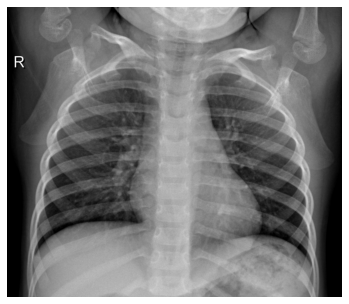

In [0]:
# Example image
ex_img = Image.open(traindir + 'NORMAL/NORMAL2-IM-0816-0001.jpeg').convert('RGB')
imshow(ex_img)


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


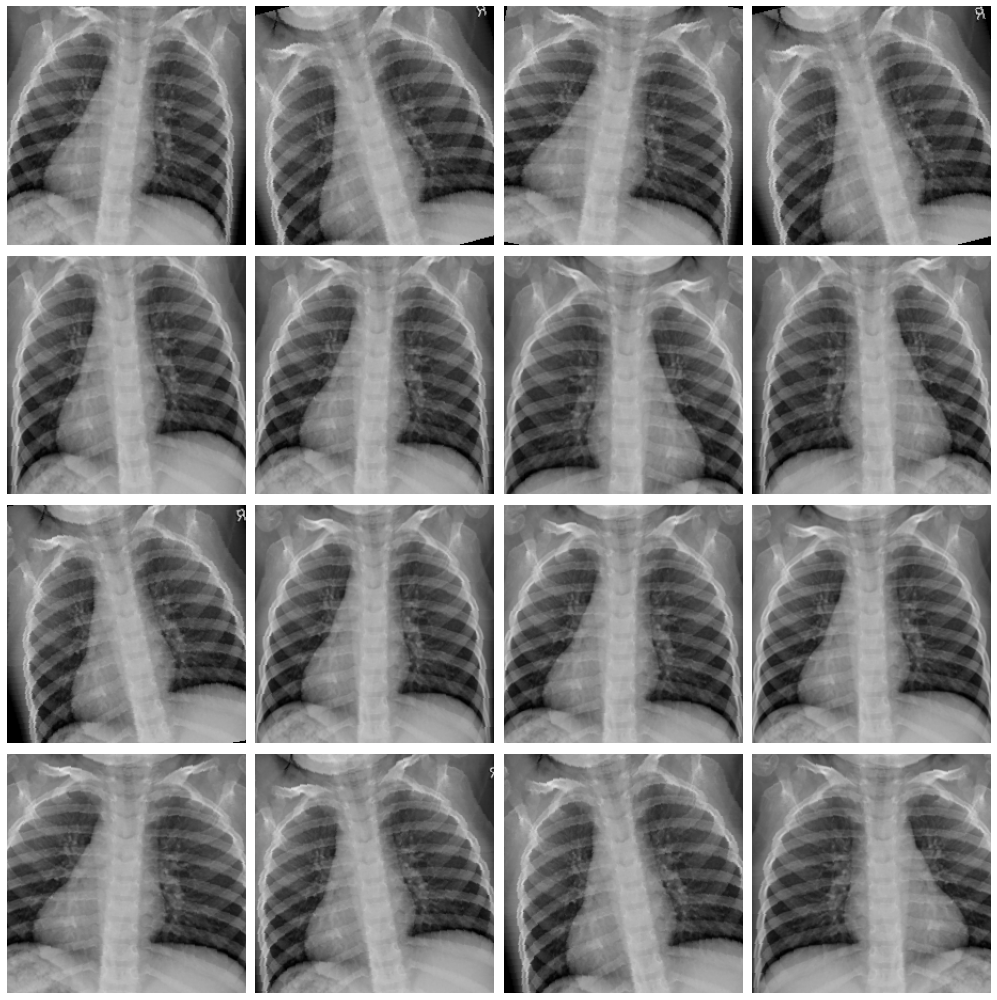

In [0]:
t = image_transforms['train']
plt.figure(figsize = (14, 14))

for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    _ = imshow_tensor(t(ex_img), ax = ax)

plt.tight_layout()

In [0]:
# Example image
ex_img = Image.open(traindir + 'NORMAL/NORMAL2-IM-0797-0001.jpeg' ).convert('RGB')
plt.figure(figsize = (15, 15))

for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    _ = imshow_tensor(t(ex_img), ax = ax)

plt.tight_layout()

## Data Iterators

In [0]:
# datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root = traindir, transform = image_transforms['train']),
    'val':
    datasets.ImageFolder(root = validdir, transform = image_transforms['val']),
    'test':
    datasets.ImageFolder(root = testdir, transform = image_transforms['test'])
    
}

# DataLoader Iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size = batch_size, shuffle = True),
    'val': DataLoader(data['val'], batch_size = batch_size, shuffle = True),
    'test': DataLoader(data['test'], batch_size = batch_size, shuffle = True)
    
}

In [0]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

The shape of a batch is `(batch_size, color_channels, height, width)`

In [0]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')
# can choose one of the two
len(data['train'].classes)

There are 2 different classes.


2

## Pre-trained models for Image classification
The model is imported and all the layers of the imported model are frozen. The last layer is created and the number of inputs are taken from the pretrained model. The inputs are given to a last layer which further generates the output.

### Different types of models


In [0]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

### Freezing early layers

In [0]:
#freeze early layers
for param in model.parameters():
  param.requires_grad = False

### Custom classifier

In [0]:
n_inputs = model.classifier[4].in_features
# Add on classifier
model.classifier[4] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.7),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))
model.classifier[4]

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.7, inplace=False)
  (3): Linear(in_features=256, out_features=2, bias=True)
  (4): LogSoftmax()
)

In [0]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

45,368,874 total parameters.
1,049,346 training parameters.


### Moving to the GPU

In [0]:
if train_on_gpu:
    model = model.to('cuda')
if multi_gpu:
    model = nn.DataParallel(model)

## Pre-trained model loading function 
The code for all the above segments under pre-trained models can be compiled under one single function.

### Loading the pre-trained model

In [0]:
model = models.alexnet(pretrained = True)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
def get_pretrained_model(model_name):
#Insert a model name in place of model_name
#currently the models that are available are resnet50 and vgg16
#model==cnn 
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'alexnet':
        model = models.alexnet(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False
        feature_extract = True
        n_inputs = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.8),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

## Summarizing the model

In [0]:
model = get_pretrained_model('alexnet')
if multi_gpu:
  summary(
      model.module,
      input_size = (3, 224, 224),
      batch_size = batch_size,
      device = 'cuda')
else:
  summary(
      model,
      input_size = (3, 224, 224),
      batch_size = batch_size,
      device = 'cuda')
#adjust the batch_size if your gpu isn't taking it too well :-)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 55, 55]          23,296
              ReLU-2           [32, 64, 55, 55]               0
         MaxPool2d-3           [32, 64, 27, 27]               0
            Conv2d-4          [32, 192, 27, 27]         307,392
              ReLU-5          [32, 192, 27, 27]               0
         MaxPool2d-6          [32, 192, 13, 13]               0
            Conv2d-7          [32, 384, 13, 13]         663,936
              ReLU-8          [32, 384, 13, 13]               0
            Conv2d-9          [32, 256, 13, 13]         884,992
             ReLU-10          [32, 256, 13, 13]               0
           Conv2d-11          [32, 256, 13, 13]         590,080
             ReLU-12          [32, 256, 13, 13]               0
        MaxPool2d-13            [32, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [32, 25

In [0]:
if multi_gpu:
    print(model.module.classifier[6])
else:
    print(model.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.8, inplace=False)
  (3): Linear(in_features=256, out_features=2, bias=True)
  (4): LogSoftmax()
)


### Mapping classes to indices

In [0]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}
list(model.idx_to_class.items())[:10]

[(0, 'NORMAL'), (1, 'PNEUMONIA')]

## Loss and Optimizer

In [0]:
#Using Negative log likelihood(NLL) loss
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
#Using adam optimizer
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([2, 256])
torch.Size([2])


## Training the model

In [0]:
!pip install livelossplot -q

In [0]:
from livelossplot import PlotLosses

In [0]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoh: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

            """ # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history
"""
    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [0]:
model, history = train(
  model,
  criterion,
  optimizer,
  dataloaders['train'],
  dataloaders['val'],
  save_file_name = 'pneumonia.pt',
  max_epochs_stop = 5,
  n_epochs = 30,
  print_every = 1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.3310 	Validation Loss: 0.4662
		Training Accuracy: 86.00%	 Validation Accuracy: 85.26%

Epoch: 1 	Training Loss: 0.2805 	Validation Loss: 0.4783
		Training Accuracy: 87.62%	 Validation Accuracy: 85.26%

Epoch: 2 	Training Loss: 0.2603 	Validation Loss: 0.5842
		Training Accuracy: 89.28%	 Validation Accuracy: 80.77%

Epoch: 3 	Training Loss: 0.2452 	Validation Loss: 0.4653
		Training Accuracy: 90.32%	 Validation Accuracy: 86.22%

Epoch: 4 	Training Loss: 0.2400 	Validation Loss: 0.4209
		Training Accuracy: 89.80%	 Validation Accuracy: 88.62%

Epoch: 5 	Training Loss: 0.2512 	Validation Loss: 0.5693
		Training Accuracy: 90.24%	 Validation Accuracy: 84.62%

Epoch: 6 	Training Loss: 0.2337 	Validation Loss: 0.5730
		Training Accuracy: 91.09%	 Validation Accuracy: 82.85%

Epoch: 7 	Training Loss: 0.2398 	Validation Loss: 0.4700
		Training Accuracy: 90.70%	 Validation Accuracy: 86.54%

Epoch: 8 	Training Loss: 0.2329 	Validation Lo

KeyboardInterrupt: ignored

## Training Results

(0.1, 2.0)

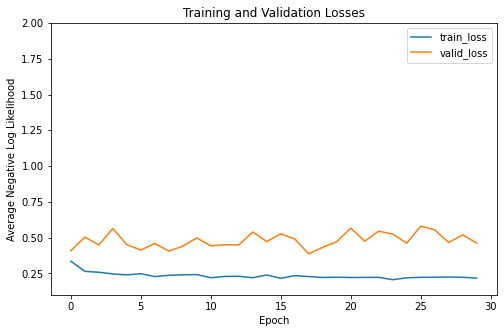

In [0]:
plt.figure(figsize = (8, 5))
for c in ['train_loss', 'valid_loss']:
    plt.plot(history[c], label = c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.gca().set_ylim(0.1, 2)

AxesSubplot(0.125,0.125;0.775x0.755)


(50.0, 100.0)

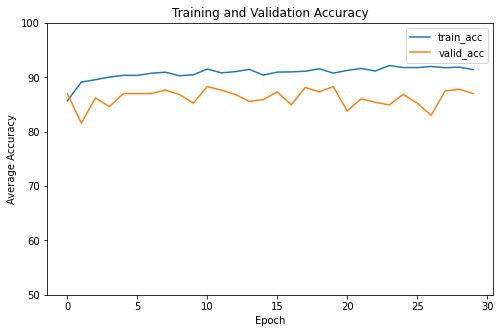

In [0]:
plt.figure(figsize = (8, 5))
for c in ['train_acc', 'valid_acc']:
    plt.plot(100 * history[c], label = c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
ax = plt.gca()
print(ax)
ax.set_ylim(50, 100)

## Save Model

In [0]:
def save_checkpoint(model, path):

    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """
    model_name = path.split('-')[0]
#    assert (model_name in ['vgg16', 'alexnet'
#                          ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'alexnet':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [0]:
save_checkpoint(model, path='alexnet-.pth')

## Load in a checkpoint

In [0]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
   # assert (model_name in ['vgg16', 'resnet50'
                     #      ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [0]:
model, optimizer= load_checkpoint(path='alexnet-.pth')
if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)

UnboundLocalError: ignored

## Testing

### processing the image

In [0]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [0]:
x = process_image(testdir + 'dragonfly/image_0015.jpg')
x.shape

### Displaying image

In [0]:
ax, image = imshow_tensor(process_image(testdir + 'dalmatian/image_0053.jpg'))

### Making prediction function


In [0]:
def predict(image_path, model, topk=5):
    
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

### Picking random image

In [0]:
np.random.seed = 100


def random_test_image():
    #Pick a random test image from the test directory
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [0]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
top_p, top_classes, real_class

### Function to Display Predictions

In [0]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

In [0]:
display_prediction(random_test_image(), model, topk=5)

## Testing Accuracy

In [0]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [0]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets, topk=(1, 5))
else:
    accuracy(model(features), targets, topk=(1, 5))

## Evaluating model over all classes

In [0]:
def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Parameters
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure
    Returns
        results: results for each category"""

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [0]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model, dataloaders['test'], criterion)
results.head()

## Test results

In [0]:
results = results.merge(cat_df, left_on='class', right_on='category').\
    drop(columns=['category'])

# Plot using seaborn
sns.lmplot(
    y='top1', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)


## Display predictions for a category

In [0]:
def display_category(model, category, n=4):
    """Display predictions for a category    
    """
    category_results = results.loc[results['class'] == category]
    print(category_results.iloc[:, :6], '/n')

    images = np.random.choice(
        os.listdir(testdir + category + '/'), size=4, replace=False)

    for img in images:
        display_prediction(testdir + category + '/' + img, model, 5)


In [0]:
display_category(model, 'pneumonia')